##### Tier II Object Based Image Analysis Field Boundary Detection 

In [89]:
import os
import rasterio
import affine
import matplotlib.pyplot as plt
import cv2
import numpy as np
import fiona
import sys

import matplotlib as mplt
import shapely
from shapely.geometry.polygon import Polygon as Poly
from shapely.geometry import MultiLineString, Polygon,MultiPolygon


from skimage.filters import sobel
from skimage import segmentation

from skimage import feature
from skimage import data
from skimage import filters
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage.filters.rank import entropy
from skimage.morphology import disk

from skimage import (transform, exposure, segmentation,
                     filters, feature, morphology)

from skimage.color import label2rgb
from scipy import ndimage as ndi

from PIL import Image

from rasterio import plot
from rasterio.plot import show,show_hist
from rasterio.features import shapes as polygonize

from matplotlib import pyplot
from rasterio.plot import show,reshape_as_raster, reshape_as_image
from rasterio.mask import mask as msk

import visualizeGrid_v1

from visualizeGrid_v1 import read_bands,plot_bands,plot_grid,aoi_zoom

import matplotlib as mpl
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

import warnings


from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.affinity import rotate,affine_transform,translate


warnings.filterwarnings('ignore')

#### Load Image and Calculate an NDVI Band

In [90]:
red = 'Bands/BB2_red.tif'
nir = 'Bands/BB2_nir.tif'
out = 'Bands/BB2_NDVI.tif'

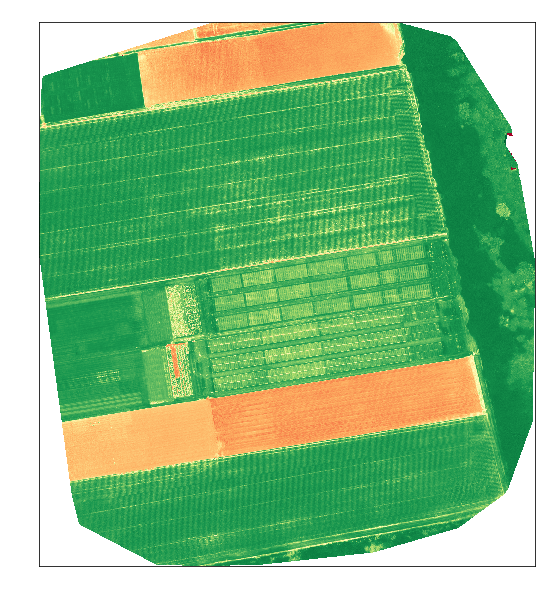

<Figure size 432x288 with 0 Axes>

In [91]:
ndvi = read_bands(red,nir,out)
affine = plot_bands(out)

##### Zoom to Area of Interest

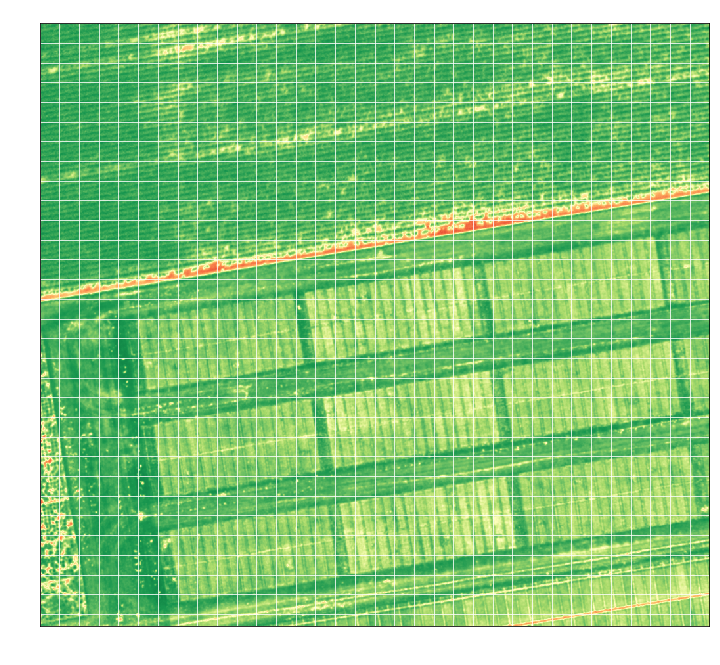

In [93]:
minx = 1300
maxx = 2300
miny =  1700
maxy = 2600
aoi_zoom(minx,maxx,miny,maxy,ndvi)

#### Clip input image to AOI extent

##### Define a bounding box 

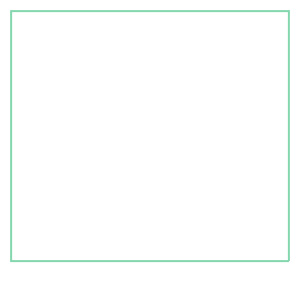

In [114]:
from shapely.affinity import rotate,affine_transform,translate
from shapely.geometry import box
from mapField import write_shapes
w, h = maxx - minx, maxy - miny
b = box(minx - 0.1*w, miny - 0.1*h, maxx + 0.1*w, maxy+0.1*h)
b.exterior

#### Project and Write Clip Box to Vector File

In [117]:
#Define the affine transform matrix
matrix = (affine[0:2]+affine[3:5]+affine[2:3]+affine[5:6])

ba = affine_transform(b,matrix)
poly = [ba]


#### Write the bounding box to a Vector file

In [118]:
write_shapes(poly,'Results/TII_clip.geojson','test.csv',['Trial#','Note'])

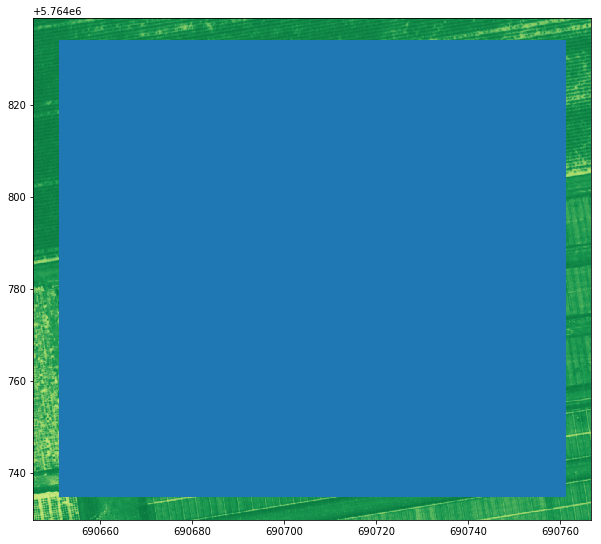

In [122]:
fig,ax = plt.subplots(figsize = (10,10))
ndvi_clip = rasterio.open(out)


with fiona.open("Results/TII_clip.geojson", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
patches = [PolygonPatch(feature, edgecolor="red", facecolor="none",alpha=0.1, linewidth=2) for feature in features]

# Add the patch to the Axes

ax.add_collection(mplt.collections.PatchCollection(patches))
ax.set_aspect(1)
ax.axis('scaled')

# Add ndvi to Axes
show((ndvi_clip,1),ax,cmap='RdYlGn')

#### Clip the NDVI GeoTiff and Save to Disk

In [12]:
with rasterio.open('Bands/BB2_NDVI.tif') as src:
    out_image, out_transform = msk(src, features, crop=True)
    out_meta = src.meta.copy()
    out_image [out_image == -10000] = np.nan
    
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "affine":out_meta['affine'],
                 'nodata': -999
                })
out_image.astype(rasterio.float32)

with rasterio.open("Results/TierII/BB2_clip.tif", "w", **out_meta) as dest:
    dest.write(out_image)

##### View the Clipped image and Zoom In

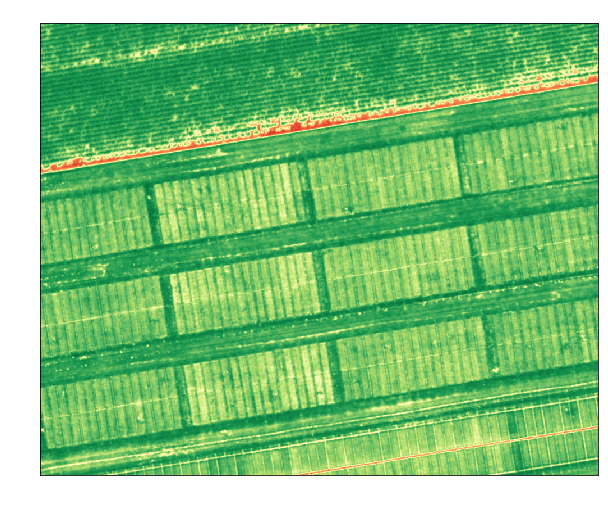

0.2125672 0.9439843


In [123]:
bbclip = "Results/TierII/BB2_clip.tif"
minx = 400
maxx = 1375
miny = 300
maxy = 1090
with rasterio.open(bbclip) as src:
    ndvi = src.read(1)
    ndvi[ndvi == -999] = np.nan
    ndvi[ndvi < -1 ] = 0
    
    
fig,ax = plt.subplots(figsize=(10,10))

w, h = maxx - minx, maxy - miny
ax.set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
ax.set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
ax.set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 200),0))
ax.set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 200),0))
ax.set_aspect(1)
plt.xticks(rotation=45,horizontalalignment='right')
   
ax.set_axis_on()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
   
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title("NDVI Band",color='#FFFFFF')


show(ndvi,cmap='RdYlGn')    

print(ndvi.min(), ndvi.max()) 

##### Smooth NDVI image to remove noise


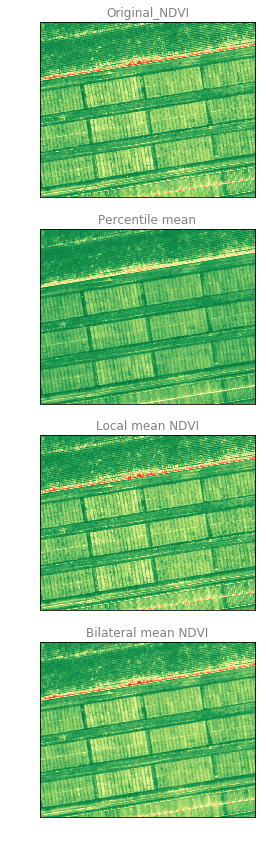

In [124]:
selem = disk(2)

pm = rank.mean_percentile(ndvi, selem=selem, p0=0.1, p1=0.9)
bm = rank.mean_bilateral(ndvi, selem=selem, s0=2, s1=2)

lm = rank.mean(ndvi, selem=selem)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,12),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original_NDVI','Percentile mean','Local mean NDVI',
          'Bilateral mean NDVI'
          ]
imgs = [ndvi,pm,bm,lm]
for n in range(0, len(imgs)):
    img = ax[n].imshow(imgs[n], cmap='RdYlGn')
    ax[n].set_title(titles[n],color='grey')
    ax[n].axis('off')
    
    w, h = maxx - minx, maxy - miny
    ax[n].set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
    ax[n].set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
    ax[n].set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 200),0))
    ax[n].set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 200),0))
    ax[n].set_aspect(1)
    plt.xticks(rotation=45,horizontalalignment='right')
   
    ax[n].set_axis_on()
    ax[n].xaxis.label.set_color('white')
    ax[n].yaxis.label.set_color('white')
    
    ax[n].tick_params(axis='x', colors='white')
    ax[n].tick_params(axis='y', colors='white')
   

plt.tight_layout()
plt.show()

##### Inspect the Histogram Values of the Smoothed Images

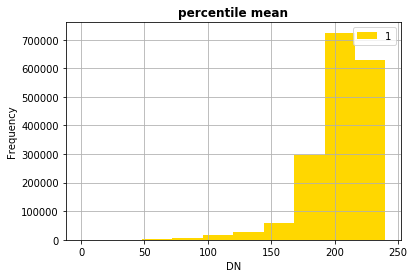

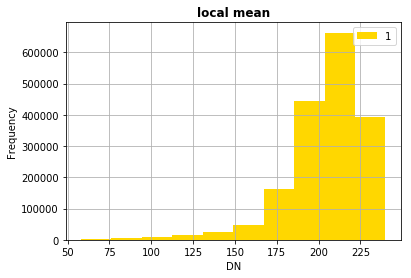

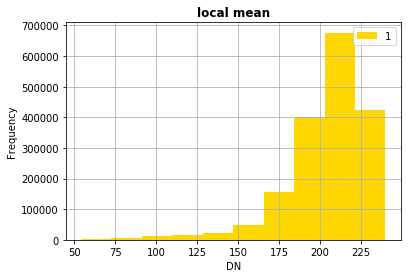

In [131]:

show_hist(pm,10,title='percentile mean')
show_hist(lm,10,title='local mean')
show_hist(bm,10,title='local mean')


##### Define Sobel Edge Detection Image on Filtered Images

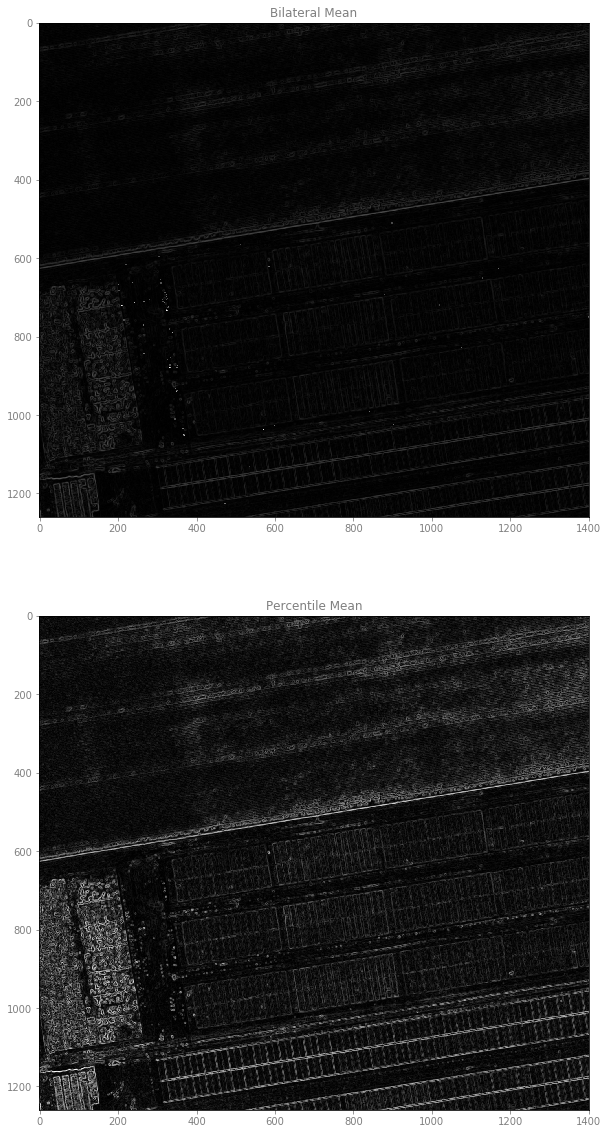

In [132]:
edges1 = sobel(pm)
edges2 = sobel(bm)
pm_edg = edges1
bm_edg = edges2

fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(20,20))

show(pm_edg,ax=ax1,cmap=plt.cm.gray,interpolation='nearest')

show(bm_edg,ax=ax2,cmap=plt.cm.gray,interpolation='nearest')
ax2.set_title(label ='Percentile Mean',color='grey')
ax1.set_title(label='Bilateral Mean',color='grey')
ax2.set_title(label ='Percentile Mean',color='grey')
ax1.set_title(label='Bilateral Mean',color='grey')
ax1.tick_params(axis='both', colors='grey')
ax2.tick_params(axis='both', colors='grey')

##### Inspect Histogram of Sobel Edge Images

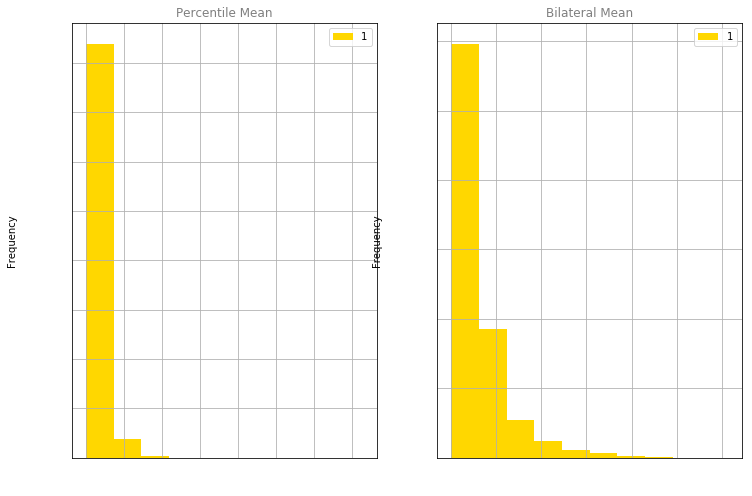

In [19]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,8))
show_hist(pm_edg,ax=ax1,bins=10)
show_hist(bm_edg,ax=ax2,bins=10)
ax1.set_title(label ='Percentile Mean',color='grey')
ax2.set_title(label='Bilateral Mean',color='grey')
ax1.xaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='both', colors='white')

#### Apply Threshold to Sobel Edge Images to remove noise

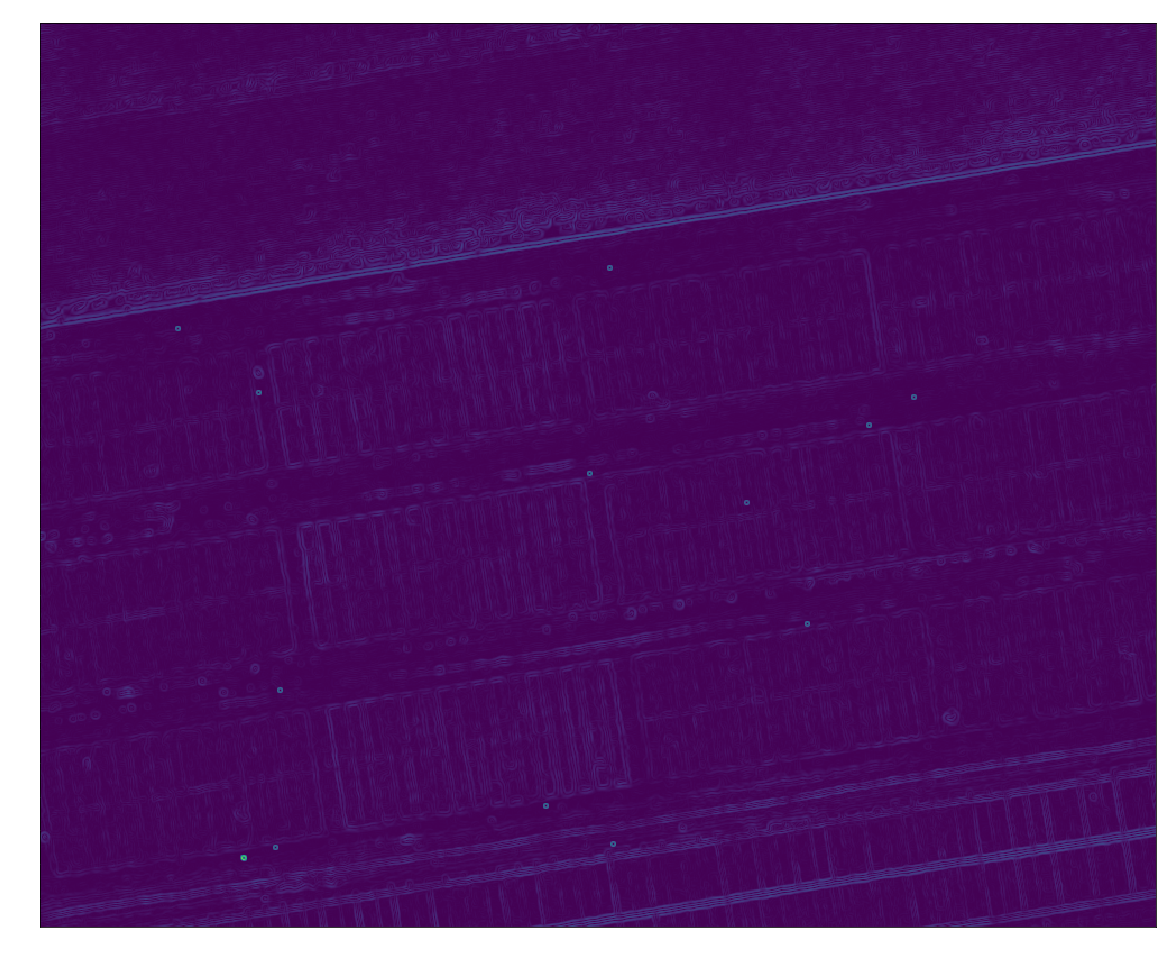

In [136]:
bounds1 =sobel(pm_edg)
bounds2 =sobel(bm_edg)

bounds1[bounds1 < 0.002] = 0
bounds2[bounds2 <  0.0012] = 0


fig,ax = plt.subplots(figsize=(20,20))
w, h = maxx - minx, maxy - miny
ax.set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
ax.set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
ax.set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 30),0))
ax.set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 30),0))
ax.set_aspect(1)
plt.xticks(rotation=45,horizontalalignment='right')
    #ax.grid(b=True, which='major', color='w', linewidth=0.8)
    #ax.grid(b=True, which='minor', color='w', linewidth=0.6)
ax.set_axis_on()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title("NDVI Band",color='#FFFFFF')
#show(img,ax,cmap='RdYlGn')
show(bounds1,ax) #,cmap='RdYlGn')
#show(bounds2,ax=ax2) #,cmap='RdYlGn')

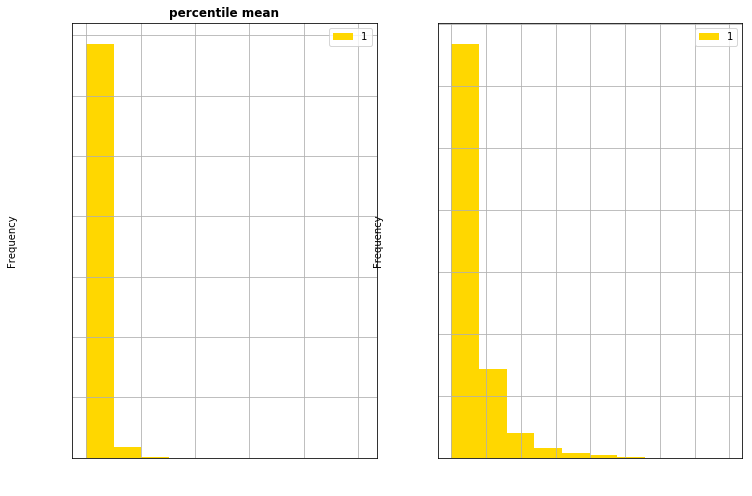

In [135]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(12,8))
show_hist(bounds1,ax=ax1,bins=10,title='percentile mean')
show_hist(bounds2,ax=ax2,bins=10,title='bilateral mean')
ax1.xaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
plt.title("percentile mean",color='#FFFFFF')
plt.title("bilateral mean",color='#FFFFFF')
ax1.tick_params(axis='both', colors='white')
ax2.tick_params(axis='both', colors='white')

###### Define a marker image (boundary/no-boundary) image to use in the segmentation process

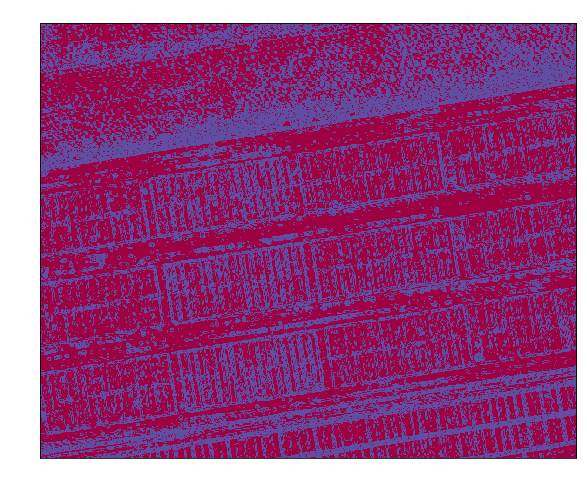

In [140]:
markers = np.zeros_like(bounds1)
markers[bounds1 == 0 ] = 0
markers[bounds1 < 0.009] = 1
markers[bounds1 > 0.009] = 2


fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(markers, cmap=plt.cm.Spectral, interpolation='nearest')
ax.set_title('markers',color='#FFFFFF')
ax.axis('off')
w, h = maxx - minx, maxy - miny
ax.set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
ax.set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
ax.set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 30),0))
ax.set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 30),0))
ax.set_aspect(1)
plt.xticks(rotation=45,horizontalalignment='right')
ax.set_axis_on()
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


#### Segment the Sobel Edge image with Marker image
##### Plot the contours of the determined segments
##### Plot the identififed segement clusters over the real image

numpy.ndarray

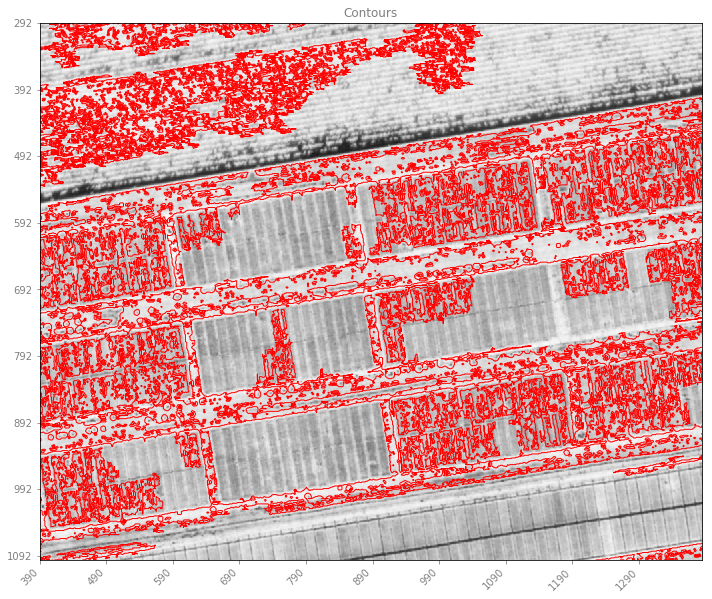

In [142]:
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = morphology.watershed(pm,markers,connectivity=10,watershed_line=True)


segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_plots, _ = ndi.label(segmentation)
plot_overlay = label2rgb(labeled_plots, image=bm)


titles = 'Contours'
fig, ax = plt.subplots( figsize=(10, 10))
ax.imshow(ndvi, cmap=plt.cm.gray, interpolation='nearest')
img= ax.contour(segmentation,levels=[0,1,2] ,linewidths=1,colors='r')#extent=(minx,maxx,miny,maxy))
ax.set_title(titles,color='grey')
ax.axis('on')
w, h = maxx - minx, maxy - miny
ax.set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
ax.set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
ax.set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 100),0))
ax.set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 100),0))
ax.set_aspect(1)
plt.xticks(rotation=45,horizontalalignment='right')

ax.set_axis_on()
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')

ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')

plt.tight_layout()
type(plot_overlay)


##### Overlay the detected plots

<class 'numpy.ndarray'>


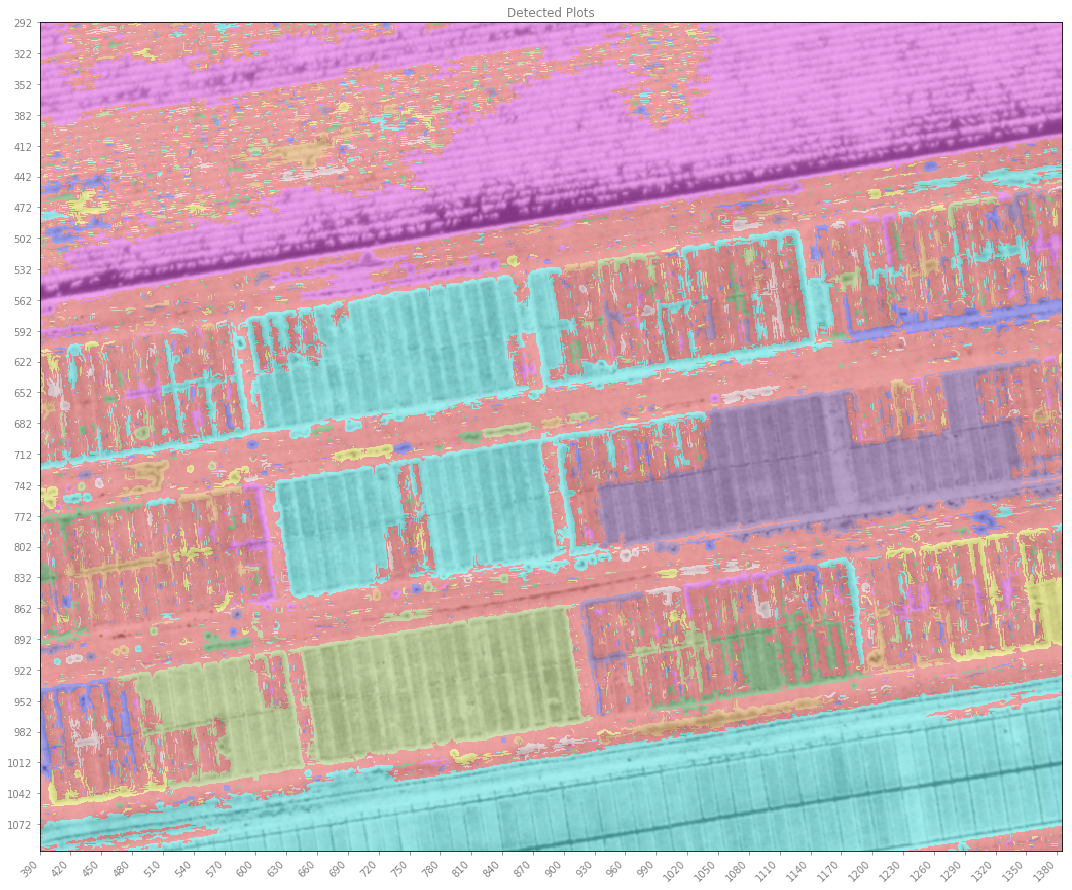

In [143]:
titles = 'Detected Plots'
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(plot_overlay, interpolation='nearest')
ax.set_title(titles)
ax.axis('on')

w, h = maxx - minx, maxy - miny
ax.set_ylim(maxy + 0.01 * h, miny - 0.01 * h)
ax.set_xlim(minx - 0.01* w, maxx + 0.01 * w)
        
ax.set_xticks(np.around(np.arange(minx - 0.01 * w, maxx + 0.01 * w, 30),0))
ax.set_yticks(np.around(np.arange(miny - 0.01 * h, maxy + 0.01 * h, 30),0))
ax.set_aspect(1)
plt.xticks(rotation=45,horizontalalignment='right')

ax.set_axis_on()
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')

ax.set_title(label=titles,color='grey')
ax.tick_params(axis='both', colors='grey')

plt.tight_layout()

##### Write Detected Plot contours to a vector file

In [144]:
def write_segments(fn, segments,mask, source_crs,
                   raster_meta, write_raster=False):
    
    segments = segments.astype('int32')
    if write_raster:
        raster_meta.update(dtype=rasterio.int32,
                           count=1,
                           compress='lzw',
                           nodata=0)
        raster_fn = os.path.splitext(fn)[0] + '.tif'
        with rasterio.open(raster_fn, 'w', **raster_meta) as gtiff:
            gtiff.write(segments)
            gtiff.write_mask(mask)

    shp_schema = {'geometry': 'Polygon', 'properties': {'id': 'int'}}
    with fiona.open(fn, 'w', driver='ESRI Shapefile',
                    crs=source_crs, schema=shp_schema) as shpfile:
        
        
        for shape, val, in polygonize(segments,
                                      transform=raster_meta['transform'],
                                      mask=mask):
            record = dict(geometry=shape, id=val, properties={'id': val})
            
            shpfile.write(record)

In [145]:
window=((miny,maxy),(minx,maxy))
#out = 'Bands/BB2_NDVI.tif'
with rasterio.open(bbclip) as src:
    tst=src.read(1)#window=window)
    meta= src.meta
    mask = tst != meta['nodata']
    #evi[evi==0] = np.nan
    #evi[evi < 0 ] = 0
    crs = src.crs


testPlot = rasterio.open(bbclip)

#mask = testPlot.read(1) != meta['nodata']
fplots = write_segments('Results/TierII/obia',
                        segmentation,mask,crs,meta,False)

#### Open the Segments that were written as polygon vector and apply a filter on area.
##### Finally find the minimum rotated rectangle of the boundaries and apply an inner buffer to account for irregular plot borders.

In [171]:

tst_plots = 'Results/TierII/obia/obia.shp'

mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open(tst_plots)])
print('Number of segment polygons:' ,len(mp))
miny, minx, maxy, maxx = mp.bounds

cm = plt.get_cmap('RdBu')
num_colours = len(mp)

area = []
for i in mp:  
    area.append(i.area)
    
maxa = max(area)
mina = min(area)
meana =sum(area) / float(len(area))

print(maxa,mina,meana)

ma = [ i for i in mp if i.area > 100 and i.area < 2000 ]
print('Number of Filtered Segment:' ,len(ma))
ma = [i.minimum_rotated_rectangle.buffer(-2) for i in ma ]

miny, minx, maxy, maxx = mp.bounds  


Number of segment polygons: 19494
5783.9078945086085 0.008443772075205986 0.7640717135714307
Number of Filtered Segment: 6


#### Plot the Filtered Polygons

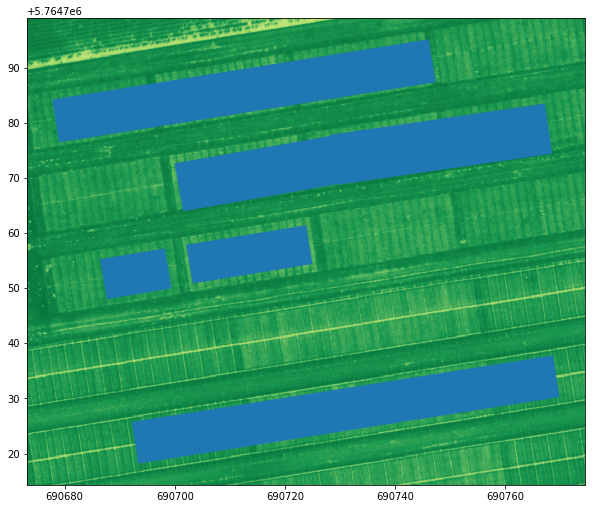

In [172]:
fig, ax = plt.subplots(figsize = (10,10))   
patches = []
for idx, p in enumerate(ma):
        colour = cm(1. * idx / num_colours)
        patches.append(PolygonPatch(p, fc=colour, ec=colour, alpha=0.65))
        
ax.add_collection(mplt.collections.PatchCollection(patches))

ax.axis('scaled')   
ax.set_aspect(2)
show((ndvi_clip,1),ax,cmap='RdYlGn')

#### Write Filtered shapes to Vector file and  Index
##### See mapField package for documentation

In [173]:
write_shapes(ma,'Results/OBIA.geojson','test.csv',['Trial#','Note'])

In [71]:
from mapField import write_shapes
matrix = (affine[0:2]+affine[3:5]+affine[2:3]+affine[5:6])

ap = list()
for i in ma:
    ap.append(affine_transform(i,matrix))